# SET ENVIRONMENT

In [44]:
# allows to import own functions
import sys
import os
import re
root_project = re.findall(r'(^\S*TFM)', os.getcwd())[0]
sys.path.append(root_project)

In [45]:
import pandas as pd
from src.features.add_features import add_features
from sklearn.model_selection import  train_test_split, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.regressor import residuals_plot, prediction_error, PredictionError
from yellowbrick.model_selection import validation_curve, learning_curve, feature_importances
from pandas_profiling import ProfileReport
import pickle
from scipy.stats import  loguniform, randint, uniform
import joblib

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt.callbacks import DeltaYStopper
from src.utils.help_func import rename_indicators

sns.set()

In [46]:
seed = 42
df_raw = pd.read_csv("../../data/processed/simulation_results_REV4.csv")
df_raw = df_raw.sample(30000, random_state=seed)
df_raw.head()

,i_country,R0,Tc,Tr,omega,ind_inf_1,ind_inf_2,ind_inf_sumgrad,ind_inf_p,ind_mort_1,ind_mort_2,ind_mort_3,ind_mort_sumgrad,n_closed,react_time,total_infected,total_deceased,total_recovered
46730,NIC,2.726164,2.880362,7.852337,0.333682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,16,13,1.0,0.0,0.0
48393,TTO,15.615708,1.581239,24.692166,0.508220,5.233333,10.139389,23.526981,0.000113,0.783439,4.970197,10.266054,10.5,15,14,359605.0,333040.0,26437.0
41416,SUR,13.349681,1.923908,25.683558,0.438960,2.000000,2.419256,6.085120,0.000104,0.850000,8.045612,8.642644,2.0,18,13,156036370.0,142061448.0,12594398.0
34506,VEN,12.878925,1.575816,20.294810,0.665217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,19,15,1.0,0.0,0.0
43725,TKM,6.054086,2.731820,16.538675,0.678012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,7,1,1.0,0.0,0.0


In [47]:
df = add_features(df_raw)
df = rename_indicators(df)

/disks/hdd2T/Drive/TFM/conda_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [48]:
df = df.loc[df['total_deceased'] > 1 ]
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

(20204, 39)
(19259, 39)


In [49]:
features = [
    'ind_1.1',
    'ind_1.2',
    'ind_1.3',
    'ind_1.4',
    'ind_2.1',
    'ind_2.2',
    'ind_2.3',
    'ind_2.4',
    'n_closed',
    'react_time',
    'betweenness_log',
    'degree_log',
    'closeness',
    'country_pop_log',
    'country_departures_log',
    'exposed_pop_log',
    'affected_population',
    'total_deceased'
    ]

df = df[features]
df.head()

,ind_1.1,ind_1.2,ind_1.3,ind_1.4,ind_2.1,ind_2.2,ind_2.3,ind_2.4,n_closed,react_time,betweenness_log,degree_log,closeness,country_pop_log,country_departures_log,exposed_pop_log,affected_population,total_deceased
48393,3.158148,-9.088466,1.655048,2.316428,2.351375,-0.244061,1.603460,2.328843,15,14,-5.547479,-2.106841,0.441352,14.144712,6.616065,19.965769,0.000044,3.330400e+05
41416,1.805846,-9.169503,0.693147,0.883460,0.693147,-0.162519,2.085127,2.156709,18,13,-8.140420,-2.917771,0.385417,13.263847,6.700731,19.249124,0.018858,1.420614e+08
24656,10.979096,-6.045470,8.352413,9.572624,9.948628,-0.634691,-0.050146,1.791781,4,9,-9.577623,-2.144581,0.393617,17.799080,9.513994,21.921267,0.473662,3.568171e+09
22411,12.998546,1.544631,9.723803,8.968487,9.553717,-2.093050,-2.184036,-0.079092,2,7,-5.853222,-2.917771,0.388792,11.580369,7.012115,19.616169,0.440854,3.321020e+09
936,12.068965,-8.469177,9.184157,10.229026,10.572662,-0.906085,-0.595658,1.349568,7,19,-3.484589,-0.574364,0.560606,21.054532,12.924383,22.212935,0.131193,9.882970e+08


In [50]:
def ResultsRegressorCV(scores):
    print(f"R2: {scores['test_r2'].mean()}, {scores['test_r2'].std()}")
    print(f"MAE: {-scores['test_neg_mean_absolute_error'].mean()}, {scores['test_neg_mean_absolute_error'].std()}")
    print(f"RMSE: {-scores['test_neg_root_mean_squared_error'].mean()}, {scores['test_neg_root_mean_squared_error'].std()}")
    return None

def make_scores(d_score, model_name):
    try:
        df = pd.read_pickle('scores_models.pkl')
        df[model_name] = list(d_score.values())
        df.to_pickle('scores_models.pkl')
    except:
        s = pd.Series(d_score)
        s.name = model_name
        df = pd.DataFrame(s)
        df.to_pickle('scores_models.pkl')

# DATA PREPARATION

In [51]:
X = df.drop(['total_deceased','affected_population'], axis=1)
y = df['total_deceased']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                  y,
                                                  random_state=seed)

# MODELS

## TOTAL DECEASED

In [52]:
pipe = Pipeline(
    [
        ("estimator", RandomForestRegressor(random_state=seed)),
    ]
)

In [53]:
score = cross_validate(pipe, X, y, n_jobs=-1, scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'])
ResultsRegressorCV(score)

R2: 0.9078190103365055, 0.005824565822730959
MAE: 249252237.8750103, 5878686.019364459
RMSE: 458230884.1921202, 17256545.11036229


## LOG TOTAL DECEASED

In [54]:
pipe = Pipeline(
    [
        ("estimator", RandomForestRegressor(random_state=seed)),
    ]
)

pipe = TransformedTargetRegressor(pipe, func=np.log, inverse_func=np.exp )

y_log = y.replace(0, np.finfo(float).eps)

In [55]:
score = cross_validate(pipe, X, y_log, n_jobs=-1, scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'])
ResultsRegressorCV(score)

R2: 0.8619070609337509, 0.005902720365322509
MAE: 292821329.8052639, 7027088.095058142
RMSE: 560944382.3396499, 15210732.651564928


# AFFECTED POPULATION

In [56]:
X = df.drop(['total_deceased','affected_population'], axis=1)
y = df['affected_population']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                  y,
                                                  random_state=seed)

In [57]:
pipe = Pipeline(
    [
        ("estimator", RandomForestRegressor(random_state=seed)),
    ]
)

In [58]:
score = cross_validate(pipe, X, y, n_jobs=-1, scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'])
ResultsRegressorCV(score)
make_scores(score,'Random Forest')

R2: 0.9078430922224061, 0.005858146131225601
MAE: 0.03311392490751091, 0.0008347058862407145
RMSE: 0.060820770831115166, 0.002320856489890647


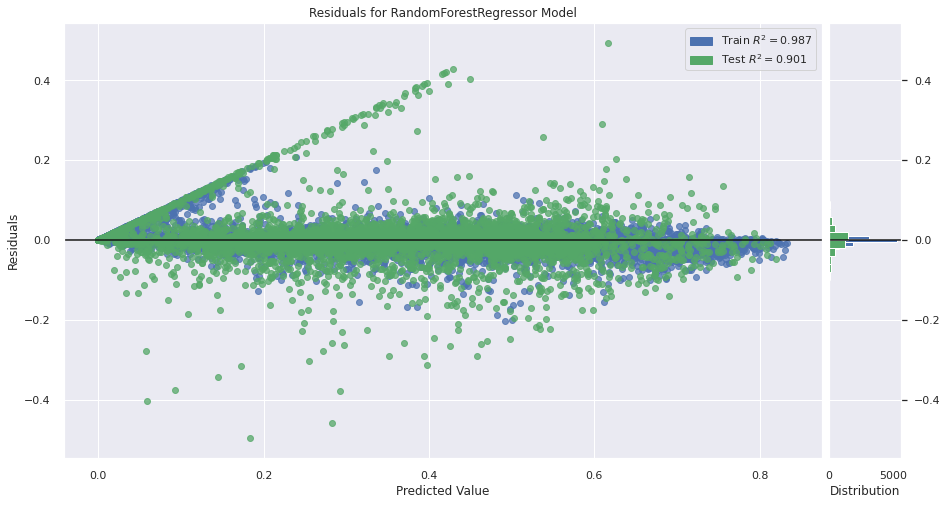

In [68]:
fig, ax = plt.subplots(1,1, figsize=(15,8))
viz = residuals_plot(pipe, X_train, y_train, X_test, y_test, ax=ax)

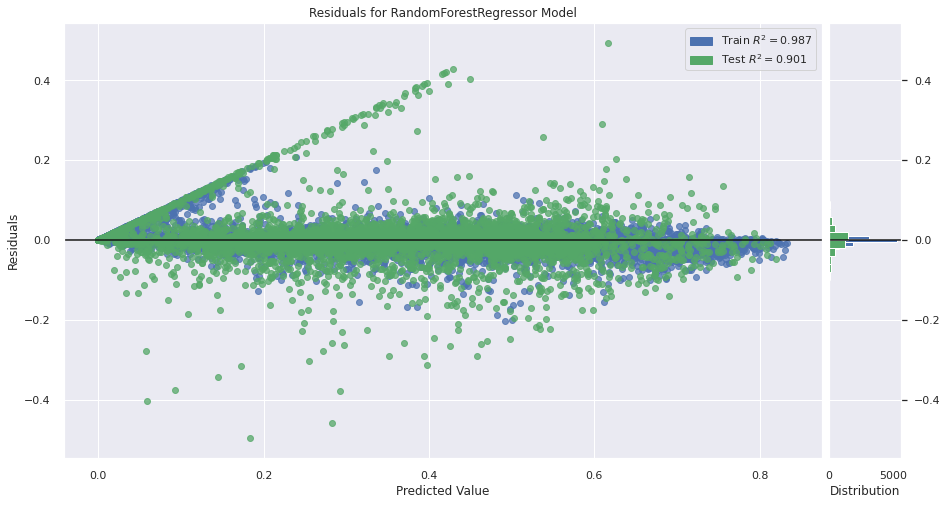

/disks/hdd2T/Drive/TFM/conda_env/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


In [ ]:
viz = prediction_error(pipe, X_train, y_train, X_test, y_test, ax=ax)

learning_curve(pipe, X, y, scoring='r2', n_jobs=-1)

feature_importances(RandomForestRegressor(random_state=seed), X, y)

## VIF

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [ ]:
X_vif = calculate_vif_(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_vif,
                                                  y,
                                                  random_state=seed)

In [ ]:
pipe = Pipeline(
    [
        ("estimator", RandomForestRegressor(random_state=seed)),
    ]
)

In [ ]:
score = cross_validate(pipe, X_vif, y, n_jobs=-1, scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'])
ResultsRegressorCV(score)

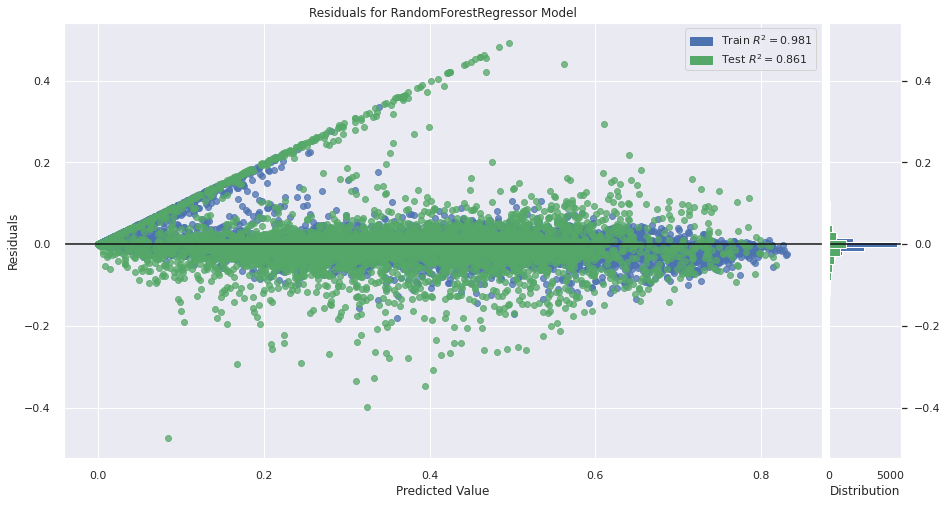

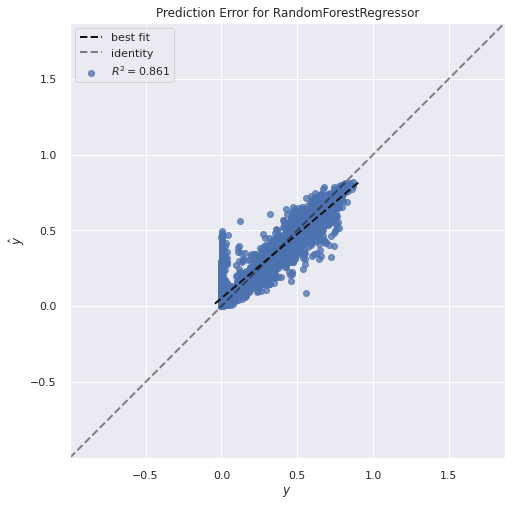

/disks/hdd2T/Drive/TFM/conda_env/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


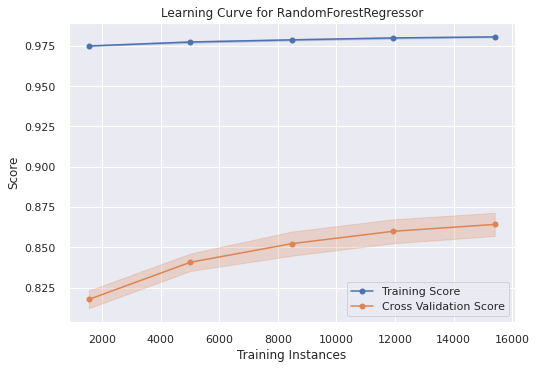

/disks/hdd2T/Drive/TFM/conda_env/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


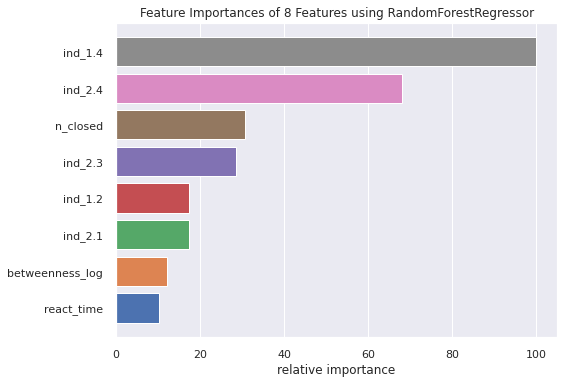

/disks/hdd2T/Drive/TFM/conda_env/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


FeatureImportances(ax=<AxesSubplot:title={'center':'Feature Importances of 8 Features using RandomForestRegressor'}, xlabel='relative importance'>,
                   model=None)

In [33]:
fig, ax = plt.subplots(1,1, figsize=(15,8))
viz = residuals_plot(pipe, X_train, y_train, X_test, y_test, ax=ax)
ax.get_legend().remove()

fig, ax = plt.subplots(1,1, figsize=(15,8))
viz = prediction_error(pipe, X_train, y_train, X_test, y_test, ax=ax)

learning_curve(pipe, X_vif, y, scoring='r2', n_jobs=-1)

feature_importances(RandomForestRegressor(random_state=seed), X_vif, y)

# FINE TUNING

In [23]:
def results_searchcv(
        cv_estimator,
        path=None,
        estimator=None,
        X_test=None,
        y_test=None):

    res_dict = {}
    res_dict['best_score_cross-val'] = cv_estimator.best_score_
    res_dict['std_cross-val'] = cv_estimator.cv_results_['std_test_R2'][cv_estimator.best_index_]
    res_dict['RMSE_cross-val'] = - \
        cv_estimator.cv_results_['mean_test_RMSE'][cv_estimator.best_index_]
    res_dict['MAE_cross-val'] = - \
        cv_estimator.cv_results_['mean_test_MAE'][cv_estimator.best_index_]
    res_dict['best_params'] = cv_estimator.best_params_

    print("=" * 20)
    print(f"Cross-val best score:\n{res_dict['best_score_cross-val']}")
    print(
        f"Cross-val std:\n{res_dict['std_cross-val']}")
    print(f"Cross-val RMSE:\n{res_dict['RMSE_cross-val']}")
    print(f"Cross-val MAE:\n{res_dict['MAE_cross-val']}")
    print(f"Best parameters found:\n{res_dict['best_params']}")
    print("=" * 20)
    
    
def results_searchcv_bayes(
        cv_estimator,
        path=None,
        estimator=None,
        X_test=None,
        y_test=None):

    res_dict = {}
    res_dict['best_score_cross-val'] = cv_estimator.best_score_
    res_dict['std_cross-val'] = cv_estimator.cv_results_['std_test_score'][cv_estimator.best_index_]
    res_dict['best_params'] = cv_estimator.best_params_

    print("=" * 20)
    print(f"Cross-val best score:\n{res_dict['best_score_cross-val']}")
    print(
        f"Cross-val std:\n{res_dict['std_cross-val']}")

    print(f"Best parameters found:\n{res_dict['best_params']}")
    print("=" * 20)

In [24]:
max_depth = [int(x) for x in np.linspace(10, 60, num=11)]
max_depth.append(None)

param_dist = {'n_estimators': randint(150, 1000),
              'max_features': ['auto','sqrt'],
              'max_depth':max_depth,
              'min_samples_split': randint(2,10),
              'min_samples_leaf': randint(1,4),
              'bootstrap': [True, False]
             }

In [25]:
scoring = {'R2': 'r2', 'RMSE': 'neg_root_mean_squared_error',
           'MAE': 'neg_mean_absolute_error'}

random_search = RandomizedSearchCV(RandomForestRegressor(random_state=seed), param_distributions=param_dist,
                                   scoring=scoring,
                                   refit='R2',                                      
                                   verbose=1, n_iter=25, 
                                   random_state=seed, n_jobs=-1)

random_search.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 25 candidates, totalling 125 fits


/disks/hdd2T/Drive/TFM/conda_env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 13.3min finished


RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), n_iter=25,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 15, 20, 25, 30, 35,
                                                      40, 45, 50, 55, 60,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9e9532ef70>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9e94838160>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9e9531e670>},
                   random_state=42, refit='R2',
                   scoring={'MAE': 'neg_mean_absolute_error', 'R2': 'r2',
                   

In [26]:
joblib.dump(random_search,'models/randomforest_randomsearch.pkl')
random_search = joblib.load('models/randomforest_randomsearch.pkl')

In [27]:
results_searchcv(random_search)

Cross-val best score:
0.9076178605582047
Cross-val std:
0.004735629424247023
Cross-val RMSE:
0.0609015340921382
Cross-val MAE:
0.03530797560098574
Best parameters found:
{'bootstrap': False, 'max_depth': 35, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 609}


In [28]:
max_depth = [int(x) for x in np.linspace(10, 60, num=11)]
max_depth.append(None)

search_space = dict(
    n_estimators=Integer(150, 1000),
    max_features=Categorical(['auto','sqrt']),
    max_depth=max_depth,
    min_samples_split=Integer(2,10),
    min_samples_leaf=Integer(1, 5),
    bootstrap=Categorical([True, False])
)


scores = []
i = 0
def on_step(optim_result, n_last=10):
    """
    Callback meant to view scores after each iteration while performing Bayesian
    Optimization in Skopt. Stops the optimization if the score in the last
    n_last iterations are equal."""
    global i
    i += 1
    scores.append(opt.best_score_)
    print(f"best score: {scores[-1]}")
    if i > n_last and len(set(scores[i-n_last:])) <= 1:
        return True

In [29]:
opt = BayesSearchCV(RandomForestRegressor(random_state=seed), search_space, random_state=seed, verbose=1,
                    n_iter=100, n_jobs=-1)

In [30]:
opt.fit(X, y, callback=on_step)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   23.1s remaining:   34.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.2s finished


best score: 0.902811707632047
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   18.0s remaining:   27.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


best score: 0.902811707632047
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


best score: 0.902811707632047
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.1s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


best score: 0.902811707632047
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   20.2s remaining:   30.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.3s finished


best score: 0.902811707632047
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.9s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


best score: 0.9037622505778642
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.0min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


best score: 0.9037622505778642
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   18.0s remaining:   27.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


best score: 0.9037622505778642
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.1s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.2s finished


best score: 0.9037622505778642
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   17.6s remaining:   26.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.7s finished


best score: 0.9037622505778642
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.3s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s finished


best score: 0.9037622505778642
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.7s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s finished


best score: 0.9037622505778642
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   31.9s remaining:   47.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.1s finished


best score: 0.9037622505778642
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   39.7s remaining:   59.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.0s finished


best score: 0.9037622505778642
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   26.9s remaining:   40.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.1s finished


best score: 0.9037622505778642


BayesSearchCV(estimator=RandomForestRegressor(random_state=42), n_iter=100,
              n_jobs=-1, random_state=42,
              search_spaces={'bootstrap': Categorical(categories=(True, False), prior=None),
                             'max_depth': [10, 15, 20, 25, 30, 35, 40, 45, 50,
                                           55, 60, None],
                             'max_features': Categorical(categories=('auto', 'sqrt'), prior=None),
                             'min_samples_leaf': Integer(low=1, high=5, prior='uniform', transform='identity'),
                             'min_samples_split': Integer(low=2, high=10, prior='uniform', transform='identity'),
                             'n_estimators': Integer(low=150, high=1000, prior='uniform', transform='identity')},
              verbose=1)

In [31]:
joblib.dump(opt,'models/randomforest_bayessearch.pkl')
opt = joblib.load('models/randomforest_bayessearch.pkl')

In [32]:
results_searchcv_bayes(opt)

Cross-val best score:
0.9037622505778642
Cross-val std:
0.00630875020641573
Best parameters found:
OrderedDict([('bootstrap', True), ('max_depth', 60), ('max_features', 'auto'), ('min_samples_leaf', 2), ('min_samples_split', 8), ('n_estimators', 467)])
